In [1]:
import FI_estimation
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as Data
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch import optim
import numpy as np
from matplotlib import pyplot as plt
import os
from scipy import ndimage

torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor

/home/maximilian/anaconda3/envs/ML/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# Gaussian
def reshape(speckles):
    reshaped = np.zeros(shape = (speckles.shape[0]*speckles.shape[1], 16,16))
    for pos in range(speckles.shape[0]):
        for i in range(speckles.shape[1]):
            reshaped[i+pos*speckles.shape[1]] = speckles[pos, i, :,:]
    return reshaped

speckles = np.load('Data'+os.sep+'normal_data.npy').astype(type) ###########################

#speckles = speckles[:,0:15000,:,:]#########
################################
print(speckles.shape)
positions = speckles.shape[0]
size = speckles.shape[1]
N_sp = positions*size
N_pix = 16

pos = np.zeros(shape = N_sp)
for i in range(N_sp):
    pos[i] = float(i*speckles.shape[1])//(N_sp)
pos = pos/(speckles.shape[1]-1)

speckles = reshape(speckles)
x_tr = np.zeros((N_sp,N_pix,N_pix))
y_tr = np.zeros((N_sp))

for k in range(N_sp): #training
    tmps = speckles[k,:,:]
    x_tr[k,:,:] = tmps
    y_tr[k] = pos[k]
x_tr = x_tr.reshape(N_sp, 1, N_pix,N_pix)
print("x_tr shape: ",x_tr.shape)
    
n_samples, n_channels, dim_x, dim_y = x_tr.shape   ### maybe dim_y, dim_x ?
def shuffle_split_data(X, y, ratio=0.5):
    arr_rand = np.random.rand(X.shape[0])
    split = arr_rand < np.percentile(arr_rand, ratio*100)

    X_train = X[split]
    y_train = y[split]
    X_test =  X[~split]
    y_test = y[~split]
    return X_train, X_test, y_train, y_test

X_train, X_val, Y_train, Y_val = shuffle_split_data(x_tr, y_tr, ratio = 0.8)

type = np.float64
X_train = X_train.astype(type)
Y_train = Y_train.astype(type)
X_val = X_val.astype(type)
Y_val = Y_val.astype(type)

type = np.float64
def reshape(speckles):
    reshaped = np.zeros(shape = (speckles.shape[0]*speckles.shape[1], speckles.shape[2]))
    for pos in range(speckles.shape[0]):
        for i in range(speckles.shape[1]):
            reshaped[i+pos*speckles.shape[1]] = speckles[pos, i, :]
    return reshaped

x_tst = np.load("Data"+os.sep+"normal_data_test.npy")
delta = 0.03 # 0.03

###### standardise
a = x_tr.shape[0]
std = np.std(x_tr, axis=0)
mean = np.mean(x_tr, axis=0)

for i in range(a): 
    x_tr[i] = (x_tr[i]-mean)/std
for i in range(x_tst.shape[0]):
    x_tst[i] = (x_tst[i]-mean[0])/std[0]

(31, 20000, 16, 16)
x_tr shape:  (620000, 1, 16, 16)


In [3]:
x_tst = x_tst.astype(np.float64)
x_minus = x_tst[0]
x_middle = x_tst[1]
x_plus = x_tst[2]

In [4]:
a = x_tr.shape[0]
std = np.std(x_tr, axis=0)
std[std==0] = 1
mean = np.mean(x_tr, axis=0)

for i in range(a): 
    x_tr[i] = (x_tr[i]-mean)/std
for i in range(x_tst.shape[0]): 
    x_tst[i] = (x_tst[i]-mean[0])/std[0]
###
cf = 4 * (np.max(y_tr)/2)**2
print("multiply the output variance with", cf)
y_tr = y_tr-np.min(y_tr)
y_tr = 2 * ( y_tr / np.max(y_tr) - 0.5 )

X_train, X_val, Y_train, Y_val = shuffle_split_data(x_tr, y_tr, ratio=0.8)
x_tr = None
y_tr = None

X_train = X_train.astype(type)
Y_train = Y_train.astype(type)
X_val = X_val.astype(type)
Y_val = Y_val.astype(type)

multiply the output variance with 1.0


In [5]:
torch.set_default_tensor_type(torch.DoubleTensor)
train_set = TensorDataset(torch.tensor(X_train), torch.tensor(Y_train).T)
val_set = TensorDataset(torch.tensor(X_val), torch.tensor(Y_val).T)
#
bs = 128
train_loader = Data.DataLoader(train_set, batch_size=bs, shuffle=True)
validation_loader = Data.DataLoader(val_set, batch_size=bs, shuffle=True)

/tmp/ipykernel_10081/3455342845.py:2: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755832681/work/aten/src/ATen/native/TensorShape.cpp:2318.)
  train_set = TensorDataset(torch.tensor(X_train), torch.tensor(Y_train).T)


In [6]:
class Model(nn.Module):
    def __init__(self, n):
        super(Model, self).__init__()
        self.linear1 = nn.Linear(n[0], n[1])
        self.linear2 = nn.Linear(n[1], n[2])
        self.linear3 = nn.Linear(n[2], n[3])
        self.linear4 = nn.Linear(n[3], n[4])
        self.linear5 = nn.Linear(n[4], n[5])
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)    
        x = F.relu(x)
        x = self.linear3(x)
        x = F.relu(x)
        x = self.linear4(x)       
        x = F.relu(x)
        x = self.linear5(x)  
        return x
n0 = 256
FI0 = 256.
n = [n0,150,100,50,25,1]

In [7]:
starting_epoch = 0
criterion =  nn.MSELoss()
n_epochs = 40
lr = 1e-6
training_loss = 0.
validation_loss = 0.
net = Model(n).to(device)
all_losses = []
all_losses_val = []
all_losses.append(training_loss/len(train_loader))
all_losses_val.append(validation_loss/len(validation_loader))
torch.save(net,  'Models' +os.sep+ 'epoch' + str(0)+'Gaussian.pth')
for epoch in range(starting_epoch, starting_epoch + n_epochs):
    #
    with torch.no_grad():
        ypr_minus = net.to('cpu')(torch.tensor(x_minus))
        ypr_middle = net.to('cpu')(torch.tensor(x_middle))
        ypr_plus = net.to('cpu')(torch.tensor(x_plus))
        lfi = ((torch.mean(ypr_plus)-torch.mean(ypr_minus))/(2*delta))**2/((torch.var(ypr_plus)+torch.var(ypr_minus))/2)
        print("lfi: ", lfi)
    #
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=0.003)
    net.train()
    training_loss = 0.
    validation_loss = 0.
    batch_count = 0
    for inputs, target in train_loader:
        inputs = inputs.to(device)
        target = target.to(device)
        batch_count += 1
        y_pred = net(inputs)
        loss = criterion(y_pred,  torch.unsqueeze(target,dim=1)  )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
    net.eval()
    with torch.no_grad():
        for inputs, target in validation_loader:
            inputs = inputs.to(device)
            target = target.to(device)
            y_pred = net(inputs)
            loss_val = criterion(y_pred,  torch.unsqueeze(target,dim=1) )
            validation_loss += loss_val.item()
    print("epoch= ", epoch, ", val= ", validation_loss/len(validation_loader),", train = ", training_loss/len(train_loader))
    torch.save(net,   'Models' +os.sep+ 'epoch' + str(epoch+1)+'Gaussian.pth')
    #
    all_losses_val.append(validation_loss/len(validation_loader))
    all_losses.append(training_loss/len(train_loader))

lfi:  tensor(0.0007)
epoch=  0 , val=  0.19912009579990833 , train =  0.2798233507977318
lfi:  tensor(122.6023)
epoch=  1 , val=  0.14006610354415125 , train =  0.15574557590154064
lfi:  tensor(174.7679)
epoch=  2 , val=  0.08349819369815435 , train =  0.12097551222269076
lfi:  tensor(199.8636)
epoch=  3 , val=  0.009008469613086753 , train =  0.04120574193252253
lfi:  tensor(220.8084)
epoch=  4 , val=  0.004551648705365713 , train =  0.005056151442762501
lfi:  tensor(226.3174)
epoch=  5 , val=  0.004391736914662994 , train =  0.004491420982118907
lfi:  tensor(230.6688)
epoch=  6 , val=  0.004291403103357745 , train =  0.004363751879921823
lfi:  tensor(234.8612)
epoch=  7 , val=  0.004198836475321684 , train =  0.004267090457599408
lfi:  tensor(238.5102)
epoch=  8 , val=  0.004119292278411314 , train =  0.004179694504883332
lfi:  tensor(241.6209)
epoch=  9 , val=  0.004063025886819416 , train =  0.004114033822925123
lfi:  tensor(244.0209)
epoch=  10 , val=  0.004026814253475393 , train

For FI based early stopping, increase the size of the network and decrease the learning rate
If y_tr is rescaled then the MSE must be rescaled accordingly in order to be comparable with 1/FI

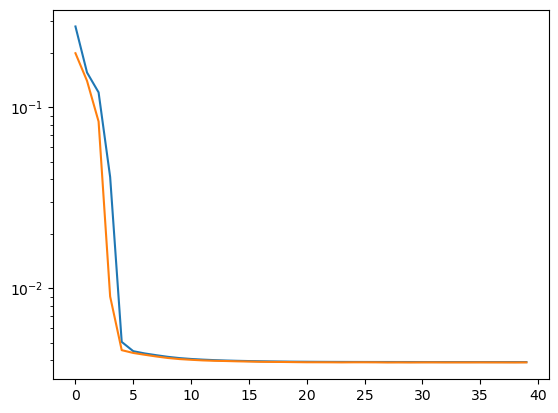

In [33]:
start = 1
plt.plot(all_losses[start:])
plt.plot(all_losses_val[start:])
plt.yscale('log')

In [34]:
# np.savez('Plots'+os.sep+'losses_normal.npz',
#          all_losses=all_losses,
#         all_losses_val = all_losses_val)

In [7]:
### calculating the FI Flow for different runs:
### parameters 
fi_in = 256
kappa = 0.1 # ratio of slopes
gamma = 0.05 # stop when the LFI doesn't improve in the first iterations 
noise = 0.01 # noise added
step = 30 # 10 increase of dimensionality
upperLimit = 500 # maximum increase 
n_epochs = 40
X = x_tst
X = X.reshape(X.shape[0]*X.shape[1], X.shape[2]*X.shape[3]) 
X = torch.tensor(X)
print("X.shape", X.shape)
fi_array = []
for epoch in range(n_epochs):
    print("epoch: ", epoch)
    net = Model(n)
    net = torch.load('Models'+os.sep + 'epoch'+ str(epoch)+'Gaussian.pth', map_location=torch.device('cpu'))
    net.eval()
    ###
    return_nodes = {
        "linear1": "linear1",
        "linear2": "linear2",
        "linear3": "linear3",
        "linear4": "linear4"}
    model2 = create_feature_extractor(net, return_nodes=return_nodes)
    intermediate_outputs = model2(X)

    linear1 = intermediate_outputs['linear1']
    linear2 = intermediate_outputs['linear2']
    linear3 = intermediate_outputs['linear3']
    linear4 = intermediate_outputs['linear4']
    layer_out = net(X)
    ##############
    linear1 = linear1.reshape(3 , linear1.shape[0]//3, linear1.shape[1])
    linear2 = linear2.reshape(3 , linear2.shape[0]//3, linear2.shape[1])
    linear3 = linear3.reshape(3 , linear3.shape[0]//3, linear3.shape[1])
    linear4 = linear4.reshape(3 , linear4.shape[0]//3, linear4.shape[1])
    layer_out = layer_out.reshape(3 , layer_out.shape[0]//3, layer_out.shape[1])
    ### converst to numpy arrays
    linear1 = linear1.detach().numpy()
    linear2 = linear2.detach().numpy()
    linear3 = linear3.detach().numpy()
    linear4 = linear4.detach().numpy()
    layer_out = layer_out.detach().numpy()
    ### it might not converge without noise!
    fi_1_temp = FI_estimation.get_LFI(linear1, delta, 1e-9)
    fi_2_temp = FI_estimation.get_LFI(linear2, delta, 1e-9)
    fi_3_temp = FI_estimation.get_LFI(linear3, delta, 1e-9)
    fi_4_temp = FI_estimation.get_LFI(linear4, delta, 1e-9)
    fi_out_temp = FI_estimation.get_LFI(layer_out, delta, 1e-9)
    if epoch == 0:
        print("lfi out: ", fi_out_temp)

    linear1 = (FI_estimation.ReLU(linear1))
    linear2 = (FI_estimation.ReLU(linear2))
    linear3 = (FI_estimation.ReLU(linear3))
    linear4 = (FI_estimation.ReLU(linear4))
    layer_out = (layer_out)

    fi_1 = FI_estimation.get_FI(linear1, delta, upperLimit, step, kappa, constant_threshold=gamma, 
                               noise_factor=noise, biasedLFI=True)
    fi_2 = FI_estimation.get_FI(linear2, delta, upperLimit, step, kappa, constant_threshold=gamma, noise_factor=noise, biasedLFI=True)
    fi_3 = FI_estimation.get_FI(linear3, delta, upperLimit, step, kappa, constant_threshold=gamma, noise_factor=noise, biasedLFI=True)
    fi_4 = FI_estimation.get_FI(linear4, delta, upperLimit, step, kappa, constant_threshold=gamma, noise_factor=noise, biasedLFI=True)
    fi_out = FI_estimation.get_FI(layer_out, delta, upperLimit, step, kappa, constant_threshold=gamma, noise_factor=noise, biasedLFI=True)

#     fi_1 = max(fi_1_temp, fi_1)
#     fi_2 = max(fi_2_temp, fi_2)
#     fi_3 = max(fi_3_temp, fi_3)
#     fi_4 = max(fi_4_temp, fi_4)
#     fi_out = max(fi_out_temp[0], fi_out)
    if isinstance(fi_out, np.ndarray): fi_out = fi_out.item()
    fi = np.array([fi_in,fi_1,fi_2,fi_3,fi_4,fi_out])
    print(fi)
    fi_array.append(fi)
    print("#------------------------------------------------------#")

X.shape torch.Size([450000, 256])
epoch:  0
lfi out:  [0.00073462]
calculating FI
up:  0


KeyboardInterrupt: 

In [18]:
temp = np.array(fi_array)
temp[:,0] = 0
temp = temp*(0.1/0.03)**2
temp[:,0] = 256.

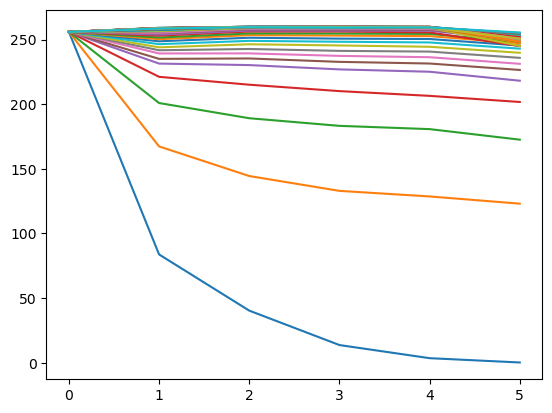

In [28]:
plt.plot(np.array(fi_array).T)

In [32]:
#np.save("Plots" + os.sep + "fi_flow_Normal.npy", np.array(fi_array))

### Trash

In [8]:
def get_LFI(data, delta, cutoff):
    mu = np.mean(data, axis=1)
    dmu = (mu[2]-mu[0])/(2*delta)
    cov = (np.cov(data[0].T)+np.cov(data[2].T))/2
    if data.shape[2] > 1:
        u, s, vh = np.linalg.svd(cov, full_matrices=True)
        count = 0
        s_inv = np.zeros(shape=s.shape[0])
        for i in range(s.shape[0]):
            if np.abs(s[i])<cutoff:
                count += 1
                s[i] = 0.
            else:
                s_inv[i] = 1/s[i]
        if count > 0:
            print("components ignored: ", count)
        lfi = dmu.T@vh.T@np.diag(s_inv)@u.T@dmu  
    elif data.shape[2] == 1:
        lfi = dmu**2/cov
    else:
        print("wrong shape of data")
    T = data.shape[1]
    N = data.shape[2]
    return lfi - 2*N/(T*(2*delta)**2)
get_LFI(linear2, delta, 1e-9)

39.46786815760878

In [13]:
#upperLimit = 1700
#step = 100
curve = FI_estimation.get_FI_curve(linear2, delta, upperLimit, step, kappa, constant_threshold=gamma, 
                               noise_factor=noise, biasedLFI=True)

lfi =  36.746851667726006
lfi =  39.69000282955167
lfi =  40.45593075995376
lfi =  40.45234452033396
lfi =  40.720608995945085
lfi =  41.08909016851445
lfi =  41.25513038216833
lfi =  41.67596467020517
lfi =  41.82030052486734
lfi =  41.49022617118201
lfi =  41.668221407039404
lfi =  41.81249955659291
lfi =  42.16153643429745
lfi =  42.53499432256317
lfi =  42.38603565410583
lfi =  42.797217518042906
lfi =  42.704802683268355


In [19]:
#curve[0] = curve[0].item()

In [14]:
x = []
for up in range(0,upperLimit,step):
    x.append(up)
x = np.array(x)
curve = np.array(curve)

In [15]:
x

array([   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000,
       1100, 1200, 1300, 1400, 1500, 1600])

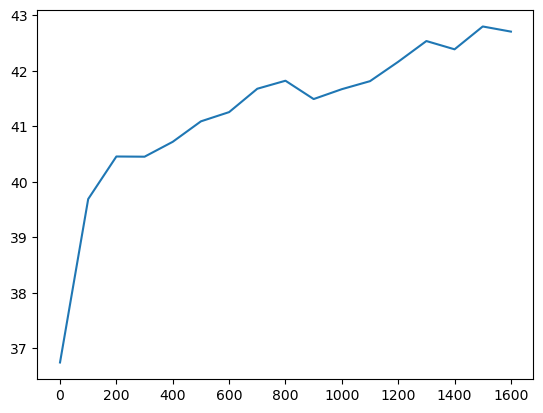

In [16]:
end = -1
plt.plot(x,curve)

In [47]:

np.savez('Plots'+os.sep+'FIConvergenceGaussian.npz',
         curve=curve,
        x=x)